# Training Convergence Plots for Learning Punctuation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
import pickle
import os
print(os.getcwd())
import time
import gc
import torch
import bisect

from conv_plots_funcs import train_conv_plots

#import empirical cdf
# import sys
# sys.path.append(os.path.abspath('../../src'))

from data_processing import gen_ckpt_steps, move_dict_to_device, get_other_err, get_mop_ratios_ckpt, compute_ratio
# sys.path.append(os.path.abspath('..'))

from check_ecdf import get_empirical_cdf

/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
Using device: cuda


In [9]:
valA = "ortho"
valC = "_ident_C"
state_dim = 5
ckpt_step = 8
batch_size = 512 #512 #4096
gpus=2
num_val_sys = 25
experiment = "250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = False
single_system = True
zero_cut = False


compute_more_ckpts = False

/home/sultand/TFs_do_KF_ICL/outputs/train_conv/training_dist_comparison_val_ortho_state_dim_5_val_sys_25_1738319448.3781545.pdf
quantiles 5 path exists?: True
ckpt_steps: [3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000, 30000, 33000, 36000, 39000, 42000, 45000, 48000, 51000, 54000, 57000, 60000, 63000, 66000, 69000, 72000, 75000, 78000, 81000, 84000, 87000, 90000, 93000, 96000, 99000, 102000, 105000, 108000, 111000, 114000, 117000, 120000, 123000, 126000, 129000, 132000, 135000, 138000, 141000, 144000, 147000, 150000, 153000, 156000, 159000, 162000, 165000, 168000, 171000, 174000, 177000, 180000]
quantiles already exist for 250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000, and single_system=True
keys in the file: ['pred_ckpts', 'quantiles']
quantiles shape after load: (0,)
loading quantiles_5 and quantiles_20
quantiles shape (0,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

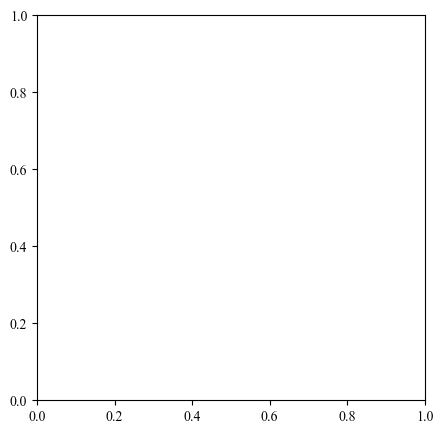

In [10]:
kal_ckpt = 141000 #60000 #81000 #28500
train_conv_plots([experiment], ["Identity"], [kal_ckpt], valA, valC, num_val_sys, compute_more_ckpts, None, 3000, 180000, 3000, state_dim, single_system=single_system, nope=nope, batch_size=batch_size, gpus=gpus, zero_cut=zero_cut)

# Zero Cut Plot

In [7]:
valA = "gaussA"
valC = "_gauss_C"
batch_size = 512 #512 #4096
gpus=2
num_val_sys = 25
experiment_zero_train = "250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
experiment_multi_train = "250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000"
kal_ckpt_zero_train = 90000 
# kal_ckpt_multi_train = 30000 #180000
datasource = "val"
state_dim = 10

In [4]:
kal_err_zero_train = get_other_err(valA, valC, kal_ckpt_zero_train, experiment_zero_train, "Kalman_rem", state_dim, zero_cut=True)

tf_err_zero_train, pred_ckpt = get_mop_ratios_ckpt(valA, valC, kal_ckpt_zero_train, experiment_zero_train, state_dim, zero_cut=True)

ols_irs = []
for ir in range(1, 4):
    ols_ir = get_other_err(valA, valC, kal_ckpt_zero_train, experiment_zero_train, f"OLS_ir_{ir}", state_dim, zero_cut=True)
    ols_irs.append(compute_ratio(None, ols_ir, kal_err_zero_train).cpu().numpy())

tf_err_rat_zero_train = compute_ratio(None, tf_err_zero_train, kal_err_zero_train)
tf_err_rat_zero_train = tf_err_rat_zero_train.cpu().numpy()
print("shape of tf_err_rat_zero_train: ", tf_err_rat_zero_train.shape)

ValueError: Preds do not exist for this checkpoint at:
../outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=90000.ckpt/zero_cut_gaussA_state_dim_10_err_lss.pkl

In [4]:
#save zero train data
os.makedirs("../outputs/GPT2/" + experiment_zero_train + "/context", exist_ok=True)
np.save("../outputs/GPT2/" + experiment_zero_train + f"/context/tf_err_rat_zero_train_step_{kal_ckpt_zero_train}.npy", tf_err_rat_zero_train)
np.save("../outputs/GPT2/" + experiment_zero_train + "/context/ols_irs_zero_train.npy", ols_irs)

In [6]:
for kal_ckpt_multi_train in np.arange(3000, 183000, 3000):
    if kal_ckpt_multi_train < 180000:
        train_conv = True
    else:
        train_conv = False

    tf_err_multi_train, pred_ckpt = get_mop_ratios_ckpt(valA, valC, kal_ckpt_multi_train, experiment_multi_train, state_dim, zero_cut=True, train_conv=train_conv)

    if tf_err_multi_train is None:
        print("No data for step: ", kal_ckpt_multi_train)
        continue
    # an_sim_err_multi_train = get_other_err(valA, valC, kal_ckpt_multi_train, experiment_multi_train, "Analytical_Simulation", state_dim, zero_cut=True, train_conv=train_conv)
    # an_sim_err_multi_train = compute_ratio(None, an_sim_err_multi_train, kal_err_zero_train).cpu().numpy()

    # ols_irs = []
    # for ir in range(1, 4):
    #     ols_ir = get_other_err(valA, valC, kal_ckpt_multi_train, experiment_zero_train, f"OLS_ir_{ir}", state_dim, zero_cut=True)
    #     ols_irs.append(compute_ratio(None, ols_ir, kal_err_zero_train).cpu().numpy())

    tf_err_rat_multi_train = compute_ratio(None, tf_err_multi_train, kal_err_zero_train)
    tf_err_rat_multi_train = tf_err_rat_multi_train.cpu().numpy()
    print("shape of tf_err_rat_multi_train: ", tf_err_rat_multi_train.shape)

    #save the data
    os.makedirs("../outputs/GPT2/" + experiment_multi_train + "/context", exist_ok=True)
    np.save("../outputs/GPT2/" + experiment_multi_train + f"/context/tf_err_rat_multi_train_step_{kal_ckpt_multi_train}.npy", tf_err_rat_multi_train)

/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=3000.ckpt/train_conv_zero_cut_gaussA_state_dim_10_err_lss.pkl
Loaded Transformer Errors
ratios shape: torch.Size([25, 2000, 251])
ratios shape after median: torch.Size([25, 251])
shape of tf_err_rat_multi_train:  (3, 251)
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=6000.ckpt/train_conv_zero_cut_gaussA_state_dim_10_err_lss.pkl
Loaded Transformer Errors
ratios shape: torch.Size([25, 2000, 251])
ratios shape after median: torch.Size([25, 251])
shape of tf_err_rat_multi_train:  (3, 251)
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=9000.ckpt/

In [26]:
#load the data
tf_err_rat_zero_train = np.load("../outputs/GPT2/" + experiment_zero_train + "/context/tf_err_rat_zero_train.npy")
ols_irs = np.load("../outputs/GPT2/" + experiment_zero_train + "/context/ols_irs_zero_train.npy")

print("tf_err_rat_zero_train: ", tf_err_rat_zero_train)


tf_err_multi_trains = []
for kal_ckpt_multi_train in np.arange(3000, 183000, 3000):

    tf_err_multi_train = np.load("../outputs/GPT2/" + experiment_multi_train + f"/context/tf_err_rat_multi_train_step_{kal_ckpt_multi_train}.npy")
    print(f"kal_ckpt_multi_train: {kal_ckpt_multi_train}, tf_err_multi_train: {tf_err_multi_train}")
    tf_err_multi_trains.append(tf_err_multi_train)

# tf_err_rat_multi_train_3k = np.load("../outputs/GPT2/" + experiment_multi_train + "/context/tf_err_rat_multi_train_step_3000.npy")
# tf_err_rat_multi_train_30k = np.load("../outputs/GPT2/" + experiment_multi_train + "/context/tf_err_rat_multi_train_step_30000.npy")
# tf_err_rat_multi_train_96k = np.load("../outputs/GPT2/" + experiment_multi_train + "/context/tf_err_rat_multi_train_step_96000.npy")
# tf_err_rat_multi_train_180k = np.load("../outputs/GPT2/" + experiment_multi_train + "/context/tf_err_rat_multi_train_step_180000.npy")



tf_err_rat_zero_train:  [[       nan        nan 0.99974203 1.7999668  1.8560532  1.8505272
  1.793606   1.7303631  1.5893804  1.5844597  1.5529317  1.5458943
  1.485755   1.4801422  1.4489886  1.4382373  1.4284878  1.3970317
  1.3516695  1.3480164  1.3618294  1.3294132  1.351551   1.3260704
  1.3129195  1.2971307  1.3056816  1.2845137  1.258776   1.2910461
  1.2756029  1.2603003  1.2583399  1.2525822  1.2513753  1.2495778
  1.2441156  1.2184424  1.2367285  1.2181895  1.2133484  1.2029514
  1.1982784  1.1978549  1.2173395  1.2132684  1.1971452  1.1901194
  1.1996632  1.1958921  1.1795571  1.1705179  1.1857657  1.1832871
  1.1843839  1.1823936  1.1757085  1.174895   1.1776067  1.1617867
  1.1646006  1.1771306  1.1526414  1.1570116  1.1582272  1.1560767
  1.1600974  1.1525854  1.1534208  1.1365782  1.1515371  1.1342643
  1.1455373  1.1378036  1.1443965  1.1412259  1.139396   1.135988
  1.1279317  1.1311492  1.1340863  1.1327556  1.1339711  1.1318856
  1.1275415  1.125544   1.1263388  1.12

In [29]:
tf_err_rat_zero_train -= 1
for ir in range(3):
    ols_irs[ir] -= 1

for i in range(len(tf_err_multi_trains)):
    tf_err_multi_trains[i] -= 1

In [3]:
def scientific_notation(value):
    """
    Returns the exponent and value of the scientific notation of an integer.
    
    Parameters:
    value (int): The integer to convert to scientific notation.
    
    Returns:
    tuple: A tuple containing the value and exponent of the scientific notation.
    """
    if value == 0:
        return (0, 0)
    
    exponent = 0
    while abs(value) >= 10:
        value /= 10
        exponent += 1
    while abs(value) < 1:
        value *= 10
        exponent -= 1

    value = round(value, 2)
    
    return (value, exponent)

In [4]:
from matplotlib.colors import BoundaryNorm, ListedColormap

[0.4        0.44166667 0.48333333 0.525      0.56666667 0.60833333
 0.65       0.69166667 0.73333333 0.775      0.81666667 0.85833333
 0.9        0.94166667 0.98333333 1.025      1.06666667 1.10833333
 1.15       1.19166667 1.23333333 1.275      1.31666667 1.35833333
 1.4       ]
25
[0.         0.02777778 0.05555556 0.08333333 0.11111111 0.13888889
 0.16666667 0.19444444 0.22222222 0.25       0.27777778 0.30555556
 0.33333333 0.36111111 0.38888889 0.41666667 0.44444444 0.47222222
 0.5        0.52777778 0.55555556 0.58333333 0.61111111 0.63888889
 0.66666667 0.69444444 0.72222222 0.75       0.77777778 0.80555556
 0.83333333 0.86111111 0.88888889 0.91666667 0.94444444 0.97222222
 1.        ]
i: 0, color_count: 0
i: 1, color_count: 1
i: 2, color_count: 2
i: 3, color_count: 3
i: 4, color_count: 4
i: 5, color_count: 5
i: 6, color_count: 6
i: 7, color_count: 7
i: 8, color_count: 8
i: 9, color_count: 9
i: 10, color_count: 10
i: 11, color_count: 11
i: 12, color_count: 12
i: 13, color_count: 13

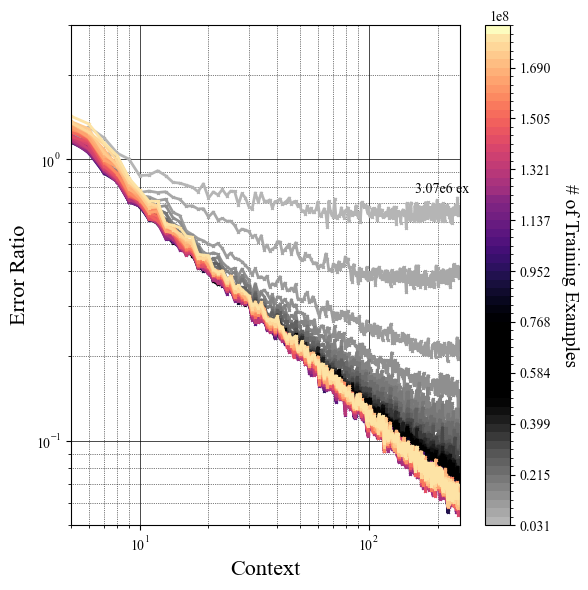

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
context_len = 251

# colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6', '#FF69B4', '#8B4513']

#make a colormap for len(tf_err_multi_trains) + 4 colors
# colors = plt.cm.viridis(np.linspace(0, 1, len(tf_err_multi_trains) + 5))
# print(np.linspace(0, 1, len(tf_err_multi_trains) + 5))
# intervals = np.linspace(0, 60, len(tf_err_multi_trains))
# intervals = (0.97)**(intervals)
# # intervals -= intervals.min()
# # intervals = 1 - intervals
# #reverse the intervals
# intervals = intervals[::-1]
# print(intervals)
# start = 0.01
# stop = 0.99
# eps = 0
# number_of_lines=len(tf_err_multi_trains)
# inter = start
# intervals = []
# for i in range(number_of_lines):
#     intervals.append(inter)
#     inter += eps
#     if i % 25 == 0:
#         eps += 0.015

# #add 1 to every element in intervals
# # intervals = np.array(intervals)
# # intervals -= 0.2
# # intervals = intervals/np.max(intervals)
# # print(intervals)

frac = 0.4
intervals = np.linspace(0,1, int(frac*len(tf_err_multi_trains))+1)
intervals = np.array(intervals)
intervals += 0.4
print(intervals)
print(len(intervals))

cmap = plt.cm.Greys
# norm = BoundaryNorm(intervals, cmap.N)


colors_1 = cmap(intervals)

intervals = np.linspace(0,1, int((1-frac)*len(tf_err_multi_trains))+1)
print(intervals)

cmap2 = plt.cm.magma
# norm2 = BoundaryNorm(intervals, cmap2.N)
colors_2 = cmap2(intervals)


combined_colors = np.vstack((colors_1, colors_2))
combined_cmap = ListedColormap(combined_colors)

combined_intervals = np.linspace(0, 1, len(combined_colors))


zero_steps = scientific_notation(2048*kal_ckpt_zero_train)
steps_180k = scientific_notation(180000*batch_size*gpus)
steps_96k = scientific_notation(96000*batch_size*gpus)
steps_30k = scientific_notation(30000*batch_size*gpus)
steps_3k = scientific_notation(3000*batch_size*gpus)

# ax.plot(np.arange(context_len), tf_err_rat_zero_train[1], label=f"Zero-cut Trained at {zero_steps[0]}e{zero_steps[1]} examples", linewidth=2, marker="x", markersize=2, zorder=5, color = colors[1])#linestyle="--")
# ax.fill_between(np.arange(context_len), tf_err_rat_zero_train[0], tf_err_rat_zero_train[2], alpha=0.2, color = colors[1])

# ax.plot(np.arange(context_len), tf_err_rat_multi_train_180k[1], label=f"Multi-cut Trained at {steps_180k[0]}e{steps_180k[1]} examples", linewidth=2, marker="x", markersize=2, zorder=4, color=colors[0])#, linestyle="-.")
# ax.fill_between(np.arange(context_len), tf_err_rat_multi_train_180k[0], tf_err_rat_multi_train_180k[2], alpha=0.2, color=colors[0])

# ax.plot(np.arange(context_len), tf_err_rat_multi_train_96k[1], label=f"Multi-cut Trained at {steps_96k[0]}e{steps_96k[1]} examples", linewidth=2, marker="x", markersize=2, zorder=3, color=colors[5])#, linestyle="-.")
# ax.fill_between(np.arange(context_len), tf_err_rat_multi_train_96k[0], tf_err_rat_multi_train_96k[2], alpha=0.2, color=colors[5])

# ax.plot(np.arange(context_len), tf_err_rat_multi_train_30k[1], label=f"Multi-cut Trained at {steps_30k[0]}e{steps_30k[1]} examples", linewidth=2, marker="x", markersize=2, zorder=2, color=colors[7])#, linestyle="-.")
# ax.fill_between(np.arange(context_len), tf_err_rat_multi_train_30k[0], tf_err_rat_multi_train_30k[2], alpha=0.2, color=colors[7])


# ax.plot(np.arange(context_len), tf_err_rat_multi_train_3k[1], label=f"Multi-cut Trained at {steps_3k[0]}e{steps_3k[1]} examples", linewidth=2, marker="x", markersize=2, zorder=2, color=colors[6])#, linestyle="-.")
# ax.fill_between(np.arange(context_len), tf_err_rat_multi_train_3k[0], tf_err_rat_multi_train_3k[2], alpha=0.2, color=colors[6])

# ax.plot(np.arange(context_len), an_sim_err_multi_train[1], label="Analytical Simulation", linewidth=2, marker=".", markersize=10)
# ax.fill_between(np.arange(context_len), an_sim_err_multi_train[0], an_sim_err_multi_train[2], alpha=0.15)

# for ir in range(1, 4):
#     ax.plot(np.arange(context_len), ols_irs[ir-1][1], label=f"OLS-{ir}", linewidth=2, marker=".", markersize=2, color=colors[ir+1])
#     ax.fill_between(np.arange(context_len), ols_irs[ir-1][0], ols_irs[ir-1][2], alpha=0.2, color=colors[ir+1])

# steps = np.arange(3000, 183000, 3000)
# examples_list = []
# colors = colors_1
# color_count = 0
# for i in range(len(tf_err_multi_trains)):
#     print(f"i: {i}, color_count: {color_count}")
#     if i > frac*len(tf_err_multi_trains):
#         colors = colors_2
#         if color_count == i:
#             color_count = 0
#     examples = steps[i]*batch_size*gpus
#     examples_list.append(examples)
#     examples = scientific_notation(examples)
#     ax.plot(np.arange(context_len), tf_err_multi_trains[i][1], label=f"Multi-cut Trained at {examples[0]}e{examples[1]} examples", linewidth=2, marker="x", markersize=2, color=colors[color_count])
#     color_count += 1


steps = np.arange(3000, 183000, 3000)
examples_list = []
color_count = 0
for i in range(len(tf_err_multi_trains)):
    print(f"i: {i}, color_count: {color_count}")
    examples = steps[i]*batch_size*gpus
    examples_list.append(examples)
    examples = scientific_notation(examples)
    ax.plot(np.arange(context_len), tf_err_multi_trains[i][1], label=f"Multi-cut Trained at {examples[0]}e{examples[1]} examples", linewidth=2, marker="x", markersize=2, color=combined_colors[color_count])
    if i == 0:

        fig.text(0.7,0.67, f"{examples[0]}e{examples[1]} ex", fontweight=10)
    color_count += 1

    # ax.fill_between(np.arange(context_len), tf_err_multi_trains[i][0], tf_err_multi_trains[i][2], alpha=0.2, color=colors[i+5])

ax.set_xlabel("Context", fontsize=16)
ax.set_xlim([5, context_len])
ax.set_ylabel("Error Ratio", fontsize=16)
# ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True)
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.set_ylim([5e-2, 3e0])

# Adding a colorbar

norm = BoundaryNorm(examples_list, combined_cmap.N)
sm = plt.cm.ScalarMappable(cmap=combined_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("# of Training Examples", fontsize=14, rotation=270, labelpad=20)

plt.tight_layout()

plt.show()

timestamp = time.strftime("%y%m%d_%H")

os.makedirs("../outputs/GPT2/" + experiment_multi_train + "/figures/context", exist_ok=True)
fig.savefig("../outputs/GPT2/" + experiment_multi_train + f"/figures/context/context_plot_{timestamp}.pdf", format="pdf")


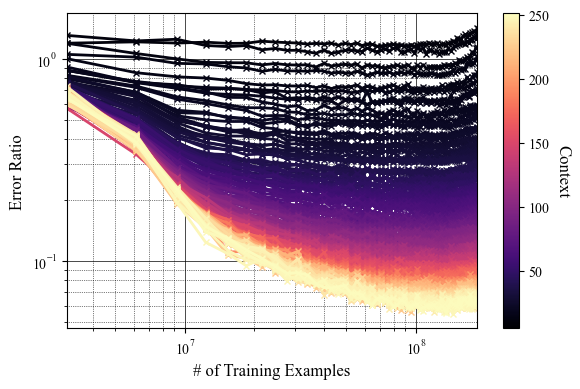

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

cmap = plt.cm.magma

colors = cmap(np.linspace(0, 1, len(np.arange(context_len))))

for context in np.arange(5, context_len):
    train_convs = [tf_err_multi_trains[i][1][context] for i in range(len(tf_err_multi_trains))]

    ax.plot(examples_list, train_convs, label=f"context: {context}", linewidth=2, marker="x", markersize=4, color=colors[context])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("# of Training Examples", fontsize=12)
ax.set_ylabel("Error Ratio", fontsize=12)
ax.set_xlim([3e3*batch_size*gpus, 180000*batch_size*gpus])
ax.grid(True)
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')

#add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=5, vmax=context_len))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Context", fontsize=12, rotation=270, labelpad=15)

plt.tight_layout()

fig_dir = "../outputs/GPT2/" + experiment_multi_train + "/figures/context"
os.makedirs(fig_dir, exist_ok=True)
timestamp = time.strftime("%y%m%d_%H%M")
fig.savefig(f"{fig_dir}/context_train_conv_plot_{timestamp}.pdf", format="pdf")

plt.show()

## zero cut train conv

In [2]:
valA = "gaussA"
valC = "_gauss_C"
state_dim = 10
batch_size = 512 #512 #4096
gpus=2
num_val_sys = 25
experiment1 = "250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
experiment2 = "250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000"
datasource = "val"
nope = False
single_system = False
zero_cut = True


compute_more_ckpts = True

/home/sultand/TFs_do_KF_ICL/outputs/train_conv/training_dist_comparison_val_gaussA_state_dim_10_val_sys_25_1738272480.9015734.pdf
quantiles 5 path exists?: True
ckpt_steps: [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000, 101000, 102000, 103000, 104000, 105000, 106000, 107000, 108000, 109000, 110000, 111000, 112000, 113000, 114000, 115000, 116000, 117000

findfont: Font family 'Times New Roman' not found.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.




i 1
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=90000.ckpt/zero_cut_gaussA_state_dim_10_err_lss.pkl
loaded Kalman_rem error
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=1000.ckpt/train_conv_zero_cut_gaussA_state_dim_10_err_lss.pkl
Loaded Transformer Errors
ratios shape: torch.Size([25, 2000, 251])
ratios shape after median: torch.Size([25, 251])
quantile shape: torch.Size([3])
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=2000.ckpt/train_conv_zero_cut_gaussA_state_dim_10_err_lss.pkl
Loaded Transformer Errors
ratios shape: torch.Size([25, 2000, 251])
rati

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

quantiles shape (91, 3)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


(array([0.2527598 , 0.41225517, 0.5662619 ], dtype=float32),
 [3072000,
  6144000,
  9216000,
  12288000,
  15360000,
  18432000,
  21504000,
  24576000,
  27648000,
  30720000,
  33792000,
  36864000,
  39936000,
  43008000,
  46080000,
  49152000,
  52224000,
  55296000,
  58368000,
  61440000,
  64512000,
  67584000,
  70656000,
  73728000,
  76800000,
  79872000,
  82944000,
  86016000,
  89088000,
  92160000,
  95232000,
  98304000,
  101376000,
  104448000,
  107520000,
  110592000,
  113664000,
  116736000,
  119808000,
  122880000,
  125952000,
  129024000,
  132096000,
  135168000,
  138240000,
  141312000,
  144384000,
  147456000,
  150528000,
  153600000,
  156672000,
  159744000,
  162816000,
  165888000,
  168960000,
  172032000,
  175104000,
  178176000,
  181248000,
  184320000])

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

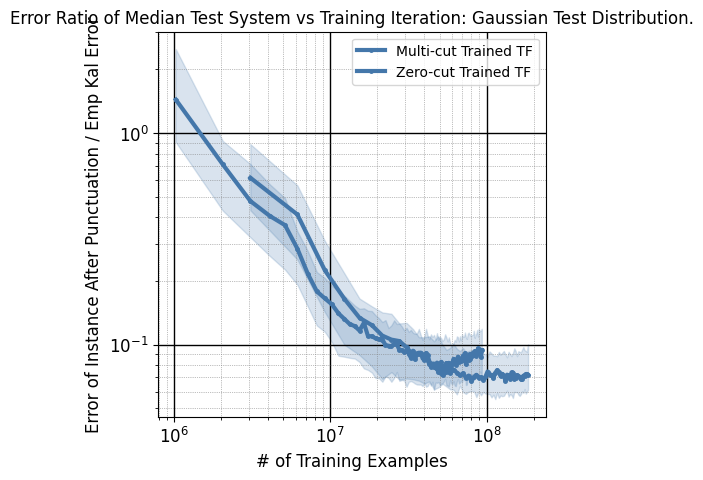

In [3]:
kal_ckpts = [180000, 90000]  #60000 #81000 #28500
train_conv_plots([experiment1, experiment2], ["Multi-cut Trained", "Zero-cut Trained"], kal_ckpts, valA, valC, num_val_sys, compute_more_ckpts, 200, 1000, 180000, 1000, state_dim, single_system=single_system, nope=nope, batch_size=batch_size, gpus=gpus, zero_cut=zero_cut)